In [1]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow,gym

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
sklearn 0.20.2
scipy 1.1.0
matplotlib 3.0.2
tensorflow 1.13.1
gym 0.10.9


**16장 – 강화 학습**

_이 노트북은 15장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [2]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os
import sys

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
from IPython.display import HTML
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# OpenAI 짐(gym)

이 노트북에서는 강화 학습 알고리즘을 개발하고 비교할 수 있는 훌륭한 도구인 [OpenAI 짐(gym)](https://gym.openai.com/)을 사용합니다. 짐은 *에이전트*가 학습할 수 있는 많은 환경을 제공합니다. `gym`을 임포트해 보죠:

In [3]:
import gym

그다음 MsPacman 환경 버전 0을 로드합니다.

In [4]:
env = gym.make('MsPacman-v0')

/home/haesun/anaconda3/envs/handson-ml/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


`reset()` 메서드를 호출하여 환경을 초기화합니다. 이 메서드는 하나의 관측을 반환합니다:

In [5]:
obs = env.reset()

관측은 환경마다 다릅니다. 여기에서는 [width, height, channels] 크기의 3D 넘파이 배열로 저장되어 있는 RGB 이미지입니다(채널은 3개로 빨강, 초록, 파랑입니다). 잠시 후에 보겠지만 다른 환경에서는 다른 오브젝트가 반환될 수 있습니다.

In [6]:
obs.shape

(210, 160, 3)

환경은 `render()` 메서드를 사용하여 화면에 나타낼 수 있고 렌더링 모드를 고를 수 있습니다(렌더링 옵션은 환경마다 다릅니다). 이 경우에는 `mode="rgb_array"`로 지정해서 넘파이 배열로 환경에 대한 이미지를 받겠습니다:

In [7]:
img = env.render(mode="rgb_array")

이미지를 그려보죠:

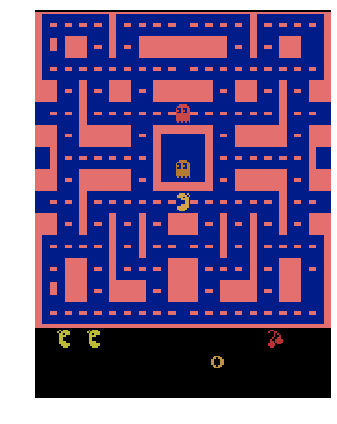

In [8]:
plt.figure(figsize=(5,6))
plt.imshow(img)
plt.axis("off")
save_fig("MsPacman")
plt.show()

1980년대로 돌아오신 걸 환영합니다! :)

이 환경에서는 렌더링된 이미지가 관측과 동일합니다(하지만 많은 경우에 그렇지 않습니다):

In [9]:
(img == obs).all()

True

환경을 그리기 위한 유틸리티 함수를 만들겠습니다:

In [10]:
def plot_environment(env, figsize=(5,6)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    plt.show()

환경을 어떻게 다루는지 보겠습니다. 에이전트는 "행동 공간"(가능한 행동의 모음)에서 하나의 행동을 선택합니다. 이 환경의 액션 공간을 다음과 같습니다:

In [11]:
env.action_space

Discrete(9)

`Discrete(9)`는 가능한 행동이 정수 0에서부터 8까지있다는 의미입니다. 이는 조이스틱의 9개의 위치(0=중앙, 1=위, 2=오른쪽, 3=왼쪽, 4=아래, 5=오른쪽위, 6=왼쪽위, 7=오른쪽아래, 8=왼쪽아래)에 해당합니다.

그다음 환경에게 플레이할 행동을 알려주고 게임의 다음 단계를 진행시킵니다. 왼쪽으로 110번을 진행하고 왼쪽아래로 40번을 진행해 보겠습니다:

In [12]:
env.reset()
for step in range(110):
    env.step(3) #왼쪽
for step in range(40):
    env.step(8) #왼쪽아래

어디에 있을까요?

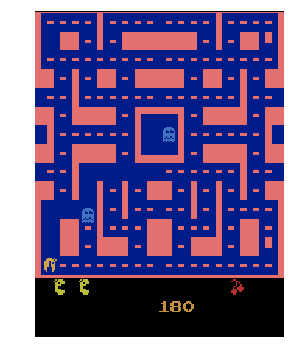

In [13]:
plot_environment(env)

사실 `step()` 함수는 여러 개의 중요한 객체를 반환해 줍니다:

In [14]:
obs, reward, done, info = env.step(0)

앞서 본 것처럼 관측은 보이는 환경을 설명합니다. 여기서는 210x160 RGB 이미지입니다:

In [15]:
obs.shape

(210, 160, 3)

환경은 마지막 스텝에서 받을 수 있는 보상을 알려 줍니다:

In [16]:
reward

0.0

게임이 종료되면 환경은 `done=True`를 반환합니다:

In [17]:
done

False

마지막으로 `info`는 환경의 내부 상태에 관한 추가 정보를 제공하는 딕셔너리입니다. 디버깅에는 유용하지만 에이전트는 학습을 위해서 이 정보를 사용하면 안됩니다(학습이 아니고 속이는 셈이므로).

In [18]:
info

{'ale.lives': 3}

10번의 스텝마다 랜덤한 방향을 선택하는 식으로 전체 게임(3개의 팩맨)을 플레이하고 각 프레임을 저장해 보겠습니다:

In [19]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode="rgb_array")
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample() # play randomly
    obs, reward, done, info = env.step(action)
    if done:
        break

이제 애니메이션으로 한번 보죠:

In [20]:
def update_scene(num, frames, patch):
    plt.close()  # 이전 그래프를 닫지 않으면 두 개의 그래프가 출력되는 matplotlib의 버그로 보입니다.
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, figsize=(5,6), repeat=False, interval=40):
    fig = plt.figure(figsize=figsize)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), 
                                   frames=len(frames), repeat=repeat, interval=interval)

In [21]:
video = plot_animation(frames)
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

환경을 더 이상 사용하지 않으면 환경을 종료하여 자원을 반납합니다:

In [22]:
env.close()

첫 번째 에이전트를 학습시키기 위해 간단한 Cart-Pole 환경을 사용하겠습니다.

# 간단한 Cart-Pole 환경

Cart-Pole은 아주 간단한 환경으로 왼쪽이나 오른쪽으로 움직일 수 있는 카트와 카트 위에 수직으로 서 있는 막대로 구성되어 있습니다. 에이전트는 카트를 왼쪽이나 오른쪽으로 움직여서 막대가 넘어지지 않도록 유지시켜야 합니다.

In [23]:
env = gym.make("CartPole-v0")

/home/haesun/anaconda3/envs/handson-ml/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [24]:
obs = env.reset()

In [25]:
obs

array([ 0.01592466, -0.02766193, -0.02049984,  0.01750777])

관측은 4개의 부동소수로 구성된 1D 넘파이 배열입니다. 각각 카트의 수평 위치, 속도, 막대의 각도(0=수직), 각속도를 나타냅니다. 이 환경을 렌더링하려면 먼저 몇 가지 이슈를 해결해야 합니다.

## 렌더링 이슈 해결하기

일부 환경(Cart-Pole을 포함하여)은 `rgb_array` 모드를 설정하더라도 별도의 창을 띄우기 위해 디스플레이 접근이 필수적입니다. 일반적으로 이 창을 무시하면 됩니다. 주피터가 헤드리스(headless) 서버로 (즉 스크린이 없이) 실행중이면 예외가 발생합니다. 이를 피하는 한가지 방법은 Xvfb 같은 가짜 X 서버를 설치하는 것입니다. `xvfb-run` 명령을 사용해 주피터를 실행합니다:

    $ xvfb-run -s "-screen 0 1400x900x24" jupyter notebook
    
주피터가 헤드리스 서버로 실행 중이지만 Xvfb를 설치하기 번거롭다면 Cart-Pole에 대해서는 다음 렌더링 함수를 사용할 수 있습니다:

In [26]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True   # 문제없음, OpenAI 짐의 렌더링 함수를 사용합니다
except Exception:
    openai_cart_pole_rendering = False  # 가능한 X 서버가 없다면, 자체 렌더링 함수를 사용합니다

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # OpenAI 짐의 렌더링 함수를 사용합니다
        return env.render(mode="rgb_array")
    else:
        # Cart-Pole 환경을 위한 렌더링 (OpenAI 짐이 처리할 수 없는 경우)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # 파랑 초록 빨강
        pole_col = 0x669acc # 파랑 초록 빨강

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

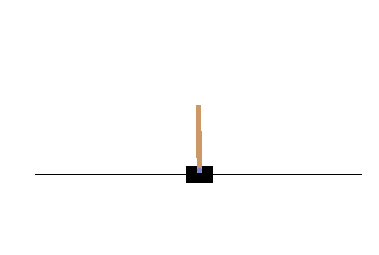

In [27]:
plot_cart_pole(env, obs)

행동 공간을 확인해 보겠습니다:

In [28]:
env.action_space

Discrete(2)

네 딱 두 개의 행동이 있네요. 왼쪽이나 오른쪽 방향으로 가속합니다. 막대가 넘어지기 전까지 카트를 왼쪽으로 밀어보죠:

In [29]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

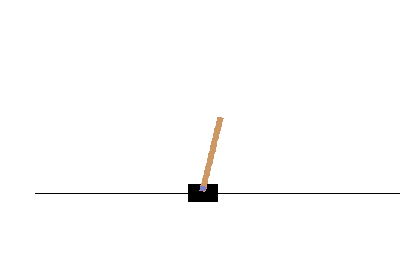

In [30]:
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis("off")
save_fig("cart_pole_plot")

In [31]:
img.shape

(400, 600, 3)

막대가 실제로 넘어지지 않더라도 너무 기울어지면 게임이 끝납니다. 환경을 다시 초기화하고 이번에는 오른쪽으로 밀어보겠습니다:

In [32]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

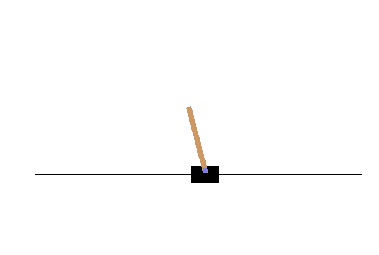

In [33]:
plot_cart_pole(env, obs)

아까 말했던 것과 같은 상황인 것 같습니다. 어떻게 막대가 똑 바로 서있게 만들 수 있을까요? 이를 위한 *정책*을 만들어야 합니다. 이 정책은 에이전트가 각 스텝에서 행동을 선택하기 위해 사용할 전략입니다. 어떤 행동을 할지 결정하기 위해 지난 행동이나 관측을 사용할 수 있습니다.

# 하드 코딩 정책

간단한 정책을 하드 코딩해 보겠습니다. 막대가 왼쪽으로 기울어지면 카트를 왼쪽으로 밀고 반대의 경우는 오른쪽으로 밉니다. 작동이 되는지 확인해 보죠:

In [34]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

In [35]:
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

아니네요, 불안정해서 몇 번 움직이고 막대가 너무 기울어져 게임이 끝났습니다. 더 똑똑한 정책이 필요합니다!

# 신경망 정책

관측을 입력으로 받고 각 관측에 대해 선택할 행동을 출력하는 신경망을 만들어 보겠습니다. 행동을 선택하기 위해 네트워크는 먼저 각 행동에 대한 확률을 추정하고 그다음 추정된 확률을 기반으로 랜덤하게 행동을 선택합니다. Cart-Pole 환경의 경우에는 두 개의 행동(왼쪽과 오른쪽)이 있으므로 하나의 출력 뉴런만 있으면 됩니다. 행동 0(왼쪽)에 대한 확률 `p`를 출력할 것입니다. 행동 1(오른쪽)에 대한 확률은 `1 - p`가 됩니다.

In [36]:
import tensorflow as tf

# 1. 네트워크 구조를 설정합니다
n_inputs = 4  # == env.observation_space.shape[0]
n_hidden = 4  # 간단한 작업이므로 너무 많은 뉴런이 필요하지 않습니다
n_outputs = 1 # 왼쪽으로 가속할 확률을 출력합니다
initializer = tf.variance_scaling_initializer()

# 2. 네트워크를 만듭니다
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
outputs = tf.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid,
                          kernel_initializer=initializer)

# 3. 추정된 확률을 기반으로 랜덤하게 행동을 선택합니다
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.


이 환경은 각 관측이 환경의 모든 상태를 포함하고 있기 때문에 지난 행동과 관측은 무시해도 괜찮습니다. 숨겨진 상태가 있다면 이 정보를 추측하기 위해 이전 행동과 상태를 고려해야 합니다. 예를 들어, 속도가 없고 카트의 위치만 있다면 현재 속도를 예측하기 위해 현재의 관측뿐만 아니라 이전 관측도 고려해야 합니다. 관측에 잡음이 있을 때도 같은 경우입니다. 현재 상태를 근사하게 추정하기 위해 과거 몇 개의 관측을 사용하는 것이 좋을 것입니다. 이 문제는 아주 간단해서 현재 관측에 잡음이 없고 환경의 모든 상태가 담겨 있습니다.

정책 네트워크에서 만든 확률을 기반으로 가장 높은 확률을 가진 행동을 고르지 않고 왜 랜덤하게 행동을 선택하는지 궁금할 수 있습니다. 이런 방식이 에이전트가 새 행동을 *탐험*하는 것과 잘 동작하는 행동을 *이용*하는 것 사이에 균형을 맞추게 합니다. 만약 어떤 레스토랑에 처음 방문했다고 가정합시다. 모든 메뉴에 대한 선호도가 동일하므로 랜덤하게 하나를 고릅니다. 이 메뉴가 맛이 좋았다면 다음에 이를 주문할 가능성을 높일 것입니다. 하지만 100% 확률이 되어서는 안됩니다. 그렇지 않으면 다른 메뉴를 전혀 선택하지 않게 되고 더 좋을 수 있는 메뉴를 시도해 보지 못하게 됩니다.

정책 신경망을 랜덤하게 초기화하고 게임 하나를 플레이해 보겠습니다:

In [37]:
n_max_steps = 1000
frames = []

with tf.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()

랜덤하게 초기화한 정책 네트워크가 얼마나 잘 동작하는지 확인해 보겠습니다:

In [38]:
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

음.. 별로 좋지 않네요. 신경망이 더 잘 학습되어야 합니다. 먼저 앞서 사용한 기본 정책을 학습할 수 있는지 확인해 보겠습니다. 막대가 왼쪽으로 기울어지면 왼쪽으로 움직이고 오른쪽으로 기울어지면 오른쪽으로 이동해야 합니다. 다음 코드는 같은 신경망이지만 타깃 확률 `y`와 훈련 연산(`cross_entropy`, `optimizer`, `training_op`)을 추가했습니다:

In [39]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits) # 행동 0(왼쪽)에 대한 확률
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

동일한 네트워크를 동시에 10개의 다른 환경에서 플레이하고 1,000번 반복동안 훈련시키겠습니다. 완료되면 환경을 리셋합니다.

In [40]:
n_environments = 10
n_iterations = 1000

envs = [gym.make("CartPole-v0") for _ in range(n_environments)]
observations = [env.reset() for env in envs]

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        target_probas = np.array([([1.] if obs[2] < 0 else [0.]) for obs in observations]) # angle<0 이면 proba(left)=1. 이 되어야 하고 그렇지 않으면 proba(left)=0. 이 되어야 합니다
        action_val, _ = sess.run([action, training_op], feed_dict={X: np.array(observations), y: target_probas})
        for env_index, env in enumerate(envs):
            obs, reward, done, info = env.step(action_val[env_index][0])
            observations[env_index] = obs if not done else env.reset()
    saver.save(sess, "./my_policy_net_basic.ckpt")

for env in envs:
    env.close()

/home/haesun/anaconda3/envs/handson-ml/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [41]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make("CartPole-v0")
    obs = env.reset()
    with tf.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames        

In [42]:
frames = render_policy_net("./my_policy_net_basic.ckpt", action, X)
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_policy_net_basic.ckpt


정책을 잘 학습한 것 같네요. 이제 스스로 더 나은 정책을 학습할 수 있는지 알아 보겠습니다.

# 정책 그래디언트

신경망을 훈련하기 위해 타깃 확률 `y`를 정의할 필요가 있습니다. 행동이 좋다면 이 확률을 증가시켜야 하고 반대로 나쁘면 이를 감소시켜야 합니다. 하지만 행동이 좋은지 나쁜지 어떻게 알 수 있을까요? 대부분의 행동으로 인한 영향은 뒤늦게 나타나는 것이 문제입니다. 게임에서 이기거나 질 때 어떤 행동이 이런 결과에 영향을 미쳤는지 명확하지 않습니다. 마지막 행동일까요? 아니면 마지막 10개의 행동일까요? 아니면 50번 스텝 앞의 행동일까요? 이를 *신용 할당 문제*라고 합니다.

*정책 그래디언트* 알고리즘은 먼저 여러번 게임을 플레이하고 성공한 게임에서의 행동을 조금 더 높게 실패한 게임에서는 조금 더 낮게 되도록 하여 이 문제를 해결합니다. 먼저 게임을 진행해 보고 다시 어떻게 한 것인지 살펴 보겠습니다.

In [43]:
import tensorflow as tf

reset_graph()

n_inputs = 4
n_hidden = 4
n_outputs = 1

learning_rate = 0.01

initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs)
outputs = tf.nn.sigmoid(logits)  # 행동 0(왼쪽)에 대한 확률
p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


In [44]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [45]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [46]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [47]:
env = gym.make("CartPole-v0")

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\r반복: {}".format(iteration), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_policy_net_pg.ckpt")

반복: 0

/home/haesun/anaconda3/envs/handson-ml/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


반복: 249

In [48]:
env.close()

In [49]:
frames = render_policy_net("./my_policy_net_pg.ckpt", action, X, n_max_steps=1000)
video = plot_animation(frames, figsize=(6,4))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

INFO:tensorflow:Restoring parameters from ./my_policy_net_pg.ckpt


# 마르코프 연쇄

In [50]:
transition_probabilities = [
        [0.7, 0.2, 0.0, 0.1],  # s0에서 s0, s1, s2, s3으로
        [0.0, 0.0, 0.9, 0.1],  # s1에서 ...
        [0.0, 1.0, 0.0, 0.0],  # s2에서 ...
        [0.0, 0.0, 0.0, 1.0],  # s3에서 ...
    ]

n_max_steps = 50

def print_sequence(start_state=0):
    current_state = start_state
    print("상태:", end=" ")
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state == 3:
            break
        current_state = np.random.choice(range(4), p=transition_probabilities[current_state])
    else:
        print("...", end="")
    print()

for _ in range(10):
    print_sequence()

상태: 0 0 3 
상태: 0 1 2 1 2 1 2 1 2 1 3 
상태: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
상태: 0 3 
상태: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
상태: 0 1 3 
상태: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 ...
상태: 0 0 3 
상태: 0 0 0 1 2 1 2 1 3 
상태: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 


# 마르코프 결정 과정

In [51]:
transition_probabilities = [
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]], # s0에서, 행동 a0이 선택되면 0.7의 확률로 상태 s0로 가고 0.3의 확률로 상태 s1로 가는 식입니다.
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None],
    ]

rewards = [
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]],
    ]

possible_actions = [[0, 1, 2], [0, 2], [1]]

def policy_fire(state):
    return [0, 2, 1][state]

def policy_random(state):
    return np.random.choice(possible_actions[state])

def policy_safe(state):
    return [0, 0, 1][state]

class MDPEnvironment(object):
    def __init__(self, start_state=0):
        self.start_state=start_state
        self.reset()
    def reset(self):
        self.total_rewards = 0
        self.state = self.start_state
    def step(self, action):
        next_state = np.random.choice(range(3), p=transition_probabilities[self.state][action])
        reward = rewards[self.state][action][next_state]
        self.state = next_state
        self.total_rewards += reward
        return self.state, reward

def run_episode(policy, n_steps, start_state=0, display=True):
    env = MDPEnvironment()
    if display:
        print("상태 (+보상):", end=" ")
    for step in range(n_steps):
        if display:
            if step == 10:
                print("...", end=" ")
            elif step < 10:
                print(env.state, end=" ")
        action = policy(env.state)
        state, reward = env.step(action)
        if display and step < 10:
            if reward:
                print("({})".format(reward), end=" ")
    if display:
        print("전체 보상 =", env.total_rewards)
    return env.total_rewards

for policy in (policy_fire, policy_random, policy_safe):
    all_totals = []
    print(policy.__name__)
    for episode in range(1000):
        all_totals.append(run_episode(policy, n_steps=100, display=(episode<5)))
    print("요약: 평균={:.1f}, 표준 편차={:1f}, 최소={}, 최대={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
    print()

policy_fire
상태 (+보상): 0 (10) 0 (10) 0 1 (-50) 2 2 2 (40) 0 (10) 0 (10) 0 (10) ... 전체 보상 = 210
상태 (+보상): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) 2 2 (40) 0 (10) ... 전체 보상 = 70
상태 (+보상): 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... 전체 보상 = 70
상태 (+보상): 0 1 (-50) 2 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 ... 전체 보상 = -10
상태 (+보상): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) ... 전체 보상 = 290
요약: 평균=121.1, 표준 편차=129.333766, 최소=-330, 최대=470

policy_random
상태 (+보상): 0 1 (-50) 2 1 (-50) 2 (40) 0 1 (-50) 2 2 (40) 0 ... 전체 보상 = -60
상태 (+보상): 0 (10) 0 0 0 0 0 (10) 0 0 0 (10) 0 ... 전체 보상 = -30
상태 (+보상): 0 1 1 (-50) 2 (40) 0 0 1 1 1 1 ... 전체 보상 = 10
상태 (+보상): 0 (10) 0 (10) 0 0 0 0 1 (-50) 2 (40) 0 0 ... 전체 보상 = 0
상태 (+보상): 0 0 (10) 0 1 (-50) 2 (40) 0 0 0 0 (10) 0 (10) ... 전체 보상 = 40
요약: 평균=-22.1, 표준 편차=88.152740, 최소=-380, 최대=200

policy_safe
상태 (+보상): 0 1 1 1 1 1 1 1 1 1 ... 전체 보상 = 0
상태 (+보상): 0 1 1 1 1 1 1 1 1 1 ... 전체 보상 = 0
상태 (+보상): 0 (10) 0 (10) 0 (1

# Q-러닝

Q-러닝은 에이전트가 플레이하는 것(가령, 랜덤하게)을 보고 점진적으로 Q-가치 추정을 향상시킵니다. 정확한 (또는 충분히 이에 가까운) Q-가치가 추정되면 최적의 정책은 가장 높은 Q-가치(즉, 그리디 정책)를 가진 행동을 선택하는 것이 됩니다.

In [52]:
n_states = 3
n_actions = 3
n_steps = 20000
alpha = 0.01
gamma = 0.99
exploration_policy = policy_random
q_values = np.full((n_states, n_actions), -np.inf)
for state, actions in enumerate(possible_actions):
    q_values[state][actions]=0

env = MDPEnvironment()
for step in range(n_steps):
    action = exploration_policy(env.state)
    state = env.state
    next_state, reward = env.step(action)
    next_value = np.max(q_values[next_state]) # 그리디한 정책
    q_values[state, action] = (1-alpha)*q_values[state, action] + alpha*(reward + gamma * next_value)

In [53]:
def optimal_policy(state):
    return np.argmax(q_values[state])

In [54]:
q_values

array([[39.13508139, 38.88079412, 35.23025716],
       [18.9117071 ,        -inf, 20.54567816],
       [       -inf, 72.53192111,        -inf]])

In [55]:
all_totals = []
for episode in range(1000):
    all_totals.append(run_episode(optimal_policy, n_steps=100, display=(episode<5)))
print("요약: 평균={:.1f}, 표준 편차={:1f}, 최소={}, 최대={}".format(np.mean(all_totals), np.std(all_totals), np.min(all_totals), np.max(all_totals)))
print()

상태 (+보상): 0 (10) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 (10) ... 전체 보상 = 230
상태 (+보상): 0 (10) 0 (10) 0 (10) 0 1 (-50) 2 2 1 (-50) 2 (40) 0 (10) ... 전체 보상 = 90
상태 (+보상): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... 전체 보상 = 170
상태 (+보상): 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) 0 (10) ... 전체 보상 = 220
상태 (+보상): 0 1 (-50) 2 (40) 0 (10) 0 1 (-50) 2 (40) 0 (10) 0 (10) 0 (10) ... 전체 보상 = -50
요약: 평균=125.6, 표준 편차=127.363464, 최소=-290, 최대=500



# DQN 알고리즘으로 미스팩맨 게임 학습하기

## 미스팩맨 환경 만들기

In [56]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

/home/haesun/anaconda3/envs/handson-ml/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


(210, 160, 3)

In [57]:
env.action_space

Discrete(9)

## 전처리

이미지 전처리는 선택 사항이지만 훈련 속도를 크게 높여 줍니다.

In [58]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # 자르고 크기를 줄입니다.
    img = img.sum(axis=2) # 흑백 스케일로 변환합니다.
    img[img==mspacman_color] = 0 # 대비를 높입니다.
    img = (img // 3 - 128).astype(np.int8) # -128~127 사이로 정규화합니다.
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

노트 `preprocess_observation()` 함수가 책에 있는 것과 조금 다릅니다. 64비트 부동소수를 -1.0~1.0 사이로 나타내지 않고 부호있는 바이트(-128~127 사이)로 표현합니다. 이렇게 하는 이유는 재생 메모리가 약 8배나 적게 소모되기 때문입니다(52GB에서 6.5GB로). 정밀도를 감소시켜도 눈에 띄이게 훈련에 미치는 영향은 없습니다.

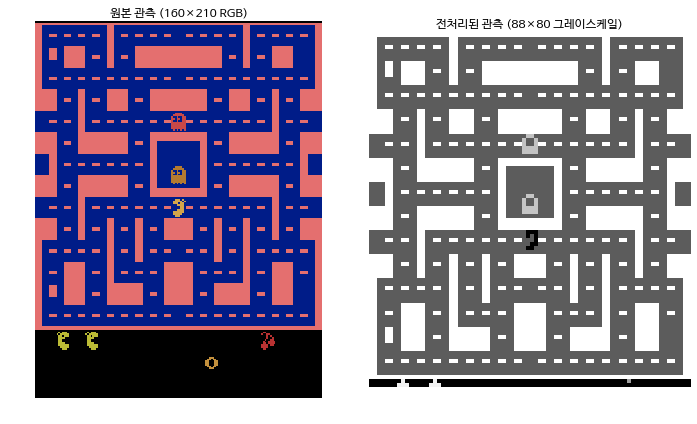

In [59]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title("원본 관측 (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("전처리된 관측 (88×80 그레이스케일)")
plt.imshow(img.reshape(88, 80), interpolation="nearest", cmap="gray")
plt.axis("off")
save_fig("preprocessing_plot")
plt.show()

## DQN 만들기

In [60]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3은 11x10 크기의 64개의 맵을 가집니다
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9개의 행동이 가능합니다
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # 픽셀 강도를 [-1.0, 1.0] 범위로 스케일 변경합니다.
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [61]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

Instructions for updating:
Use keras.layers.conv2d instead.


In [62]:
online_vars

{'/conv2d/kernel:0': <tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>,
 '/conv2d/bias:0': <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>,
 '/conv2d_1/kernel:0': <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>,
 '/conv2d_1/bias:0': <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>,
 '/conv2d_2/kernel:0': <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>,
 '/conv2d_2/bias:0': <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>,
 '/dense/kernel:0': <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>,
 '/dense/bias:0': <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>,
 '/dense_1/kernel:0': <tf.Variable 'q_networks/online/dense_1/kernel:0' shape=(512, 9) dtype=float32_ref>,
 '/dense_1/bias:0': <tf.Variable 'q_networks/onl

In [63]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


노트: 처음 책을 쓸 때는 타깃 Q-가치(y)와 예측 Q-가치(q_value) 사이의 제곱 오차를 사용했습니다. 하지만 매우 잡음이 많은 경험 때문에 작은 오차(1.0 이하)에 대해서만 손실에 이차식을 사용하고, 큰 오차에 대해서는 위의 계산식처럼 선형적인 손실(절대 오차의 두 배)을 사용하는 것이 더 낫습니다. 이렇게 하면 큰 오차가 모델 파라미터를 너무 많이 변경하지 못합니다. 또 몇 가지 하이퍼파라미터를 조정했습니다(작은 학습률을 사용하고 논문에 따르면 적응적 경사 하강법 알고리즘이 이따금 나쁜 성능을 낼 수 있으므로 Adam 최적화대신 네스테로프 가속 경사를 사용합니다). 아래에서 몇 가지 다른 하이퍼파라미터도 수정했습니다(재생 메모리 크기 확대, e-그리디 정책을 위한 감쇠 단계 증가, 할인 계수 증가, 온라인 DQN에서 타깃 DQN으로 복사 빈도 축소 등입니다).

In [64]:
from collections import deque

replay_memory_size = 500000
replay_memory = deque([], maxlen=replay_memory_size)

def sample_memories(batch_size):
    indices = np.random.permutation(len(replay_memory))[:batch_size]
    cols = [[], [], [], [], []] # 상태, 행동, 보상, 다음 상태, 계속
    for idx in indices:
        memory = replay_memory[idx]
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

### ReplayMemory 클래스를 사용한 방법 ==================

랜덤 억세스(random access)가 훨씬 빠르기 때문에 deque 대신에 ReplayMemory 클래스를 사용합니다(기여해 준 @NileshPS 님 감사합니다). 또 기본적으로 중복을 허용하여 샘플하면 큰 재생 메모리에서 중복을 허용하지 않고 샘플링하는 것보다 훨씬 빠릅니다.

In [65]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # 더 빠름
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [66]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)

In [67]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # 상태, 행동, 보상, 다음 상태, 계속
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

### =============================================

In [68]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # 랜덤 행동
    else:
        return np.argmax(q_values) # 최적 행동

In [69]:
n_steps = 4000000  # 전체 훈련 스텝 횟수
training_start = 10000  # 10,000번 게임을 반복한 후에 훈련을 시작합니다
training_interval = 4  # 4번 게임을 반복하고 훈련 스텝을 실행합니다
save_steps = 1000  # 1,000번 훈련 스텝마다 모델을 저장합니다
copy_steps = 10000  # 10,000번 훈련 스텝마다 온라인 DQN을 타깃 DQN으로 복사합니다
discount_rate = 0.99
skip_start = 90  # 게임의 시작 부분은 스킵합니다 (시간 낭비이므로).
batch_size = 50
iteration = 0  # 게임 반복횟수
checkpoint_path = "./my_dqn.ckpt"
done = True # 환경을 리셋해야 합니다

학습 과정을 트래킹하기 위해 몇 개의 변수가 필요합니다:

In [70]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

이제 훈련 반복 루프입니다!

In [71]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print("\r반복 {}\t훈련 스텝 {}/{} ({:.1f})%\t손실 {:5f}\t평균 최대-Q {:5f}   ".format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q), end="")
        if done: # 게임이 종료되면 다시 시작합니다
            obs = env.reset()
            for skip in range(skip_start): # 게임 시작 부분은 스킵합니다
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # 온라인 DQN이 해야할 행동을 평가합니다
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # 온라인 DQN으로 게임을 플레이합니다.
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # 재생 메모리에 기록합니다
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # 트래킹을 위해 통계값을 계산합니다 (책에는 없습니다)
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # 워밍엄 시간이 지난 후에 일정 간격으로 훈련합니다
        
        # 메모리에서 샘플링하여 타깃 Q-가치를 얻기 위해 타깃 DQN을 사용합니다
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # 온라인 DQN을 훈련시킵니다
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # 온라인 DQN을 타깃 DQN으로 일정 간격마다 복사합니다
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # 일정 간격으로 저장합니다
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt
반복 13992	훈련 스텝 3999999/4000000 (100.0)%	손실 1.739694	평균 최대-Q 221.029893    

아래 셀에서 에이전트를 테스트하기 위해 언제든지 위의 셀을 중지할 수 있습니다. 그런다음 다시 위의 셀을 실행하면 마지막으로 저장된 파라미터를 로드하여 훈련을 다시 시작할 것입니다.

In [72]:
frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # 온라인 DQN이 해야할 행동을 평가합니다
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # 온라인 DQN이 게임을 플레이합니다
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


In [73]:
video = plot_animation(frames, figsize=(5,6))
HTML(video.to_html5_video())  # HTML5 동영상으로 만들어 줍니다

# 추가 자료

## 브레이크아웃(Breakout)을 위한 전처리

다음은 Breakout-v0 아타리 게임을 위한 DQN을 훈련시키기 위해 사용할 수 있는 전처리 함수입니다:

In [74]:
def preprocess_observation(obs):
    img = obs[34:194:2, ::2] # 자르고 크기를 줄입니다.
    return np.mean(img, axis=2).reshape(80, 80) / 255.0

In [75]:
env = gym.make("Breakout-v0")
obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)

img = preprocess_observation(obs)

/home/haesun/anaconda3/envs/handson-ml/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


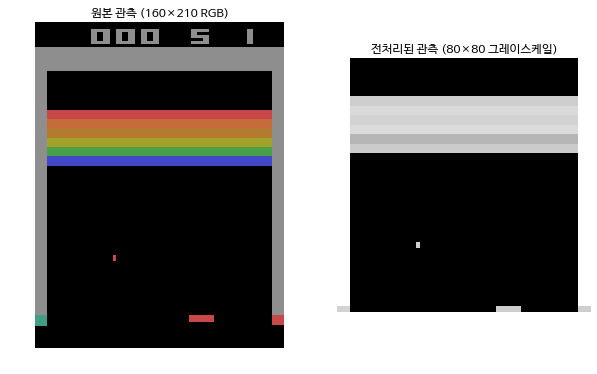

In [76]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title("원본 관측 (160×210 RGB)")
plt.imshow(obs)
plt.axis("off")
plt.subplot(122)
plt.title("전처리된 관측 (80×80 그레이스케일)")
plt.imshow(img, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

여기서 볼 수 있듯이 하나의 이미지는 볼의 방향과 속도에 대한 정보가 없습니다. 이 정보들은 이 게임에 아주 중요합니다. 이런 이유로 실제로 몇 개의 연속된 관측을 연결하여 환경의 상태를 표현하는 것이 좋습니다. 한 가지 방법은 관측당 하나의 채널을 할당하여 멀티 채널 이미지를 만드는 것입니다. 다른 방법은 `np.max()` 함수를 사용해 최근의 관측을 모두 싱글 채널 이미지로 합치는 것입니다. 여기에서는 이전 이미지를 흐리게하여 DQN이 현재와 이전을 구분할 수 있도록 했습니다.

In [77]:
from collections import deque

def combine_observations_multichannel(preprocessed_observations):
    return np.array(preprocessed_observations).transpose([1, 2, 0])

def combine_observations_singlechannel(preprocessed_observations, dim_factor=0.5):
    dimmed_observations = [obs * dim_factor**index
                           for index, obs in enumerate(reversed(preprocessed_observations))]
    return np.max(np.array(dimmed_observations), axis=0)

n_observations_per_state = 3
preprocessed_observations = deque([], maxlen=n_observations_per_state)

obs = env.reset()
for step in range(10):
    obs, _, _, _ = env.step(1)
    preprocessed_observations.append(preprocess_observation(obs))

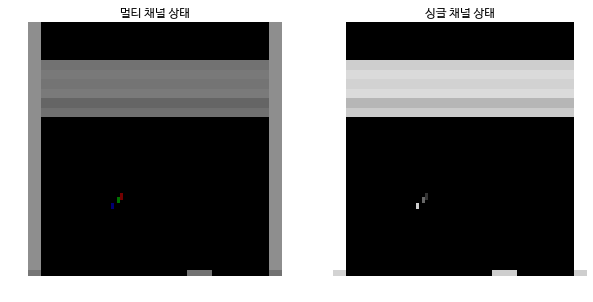

In [78]:
img1 = combine_observations_multichannel(preprocessed_observations)
img2 = combine_observations_singlechannel(preprocessed_observations)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.title("멀티 채널 상태")
plt.imshow(img1, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.title("싱글 채널 상태")
plt.imshow(img2, interpolation="nearest", cmap="gray")
plt.axis("off")
plt.show()

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. BipedalWalker-v2

*문제: 정책 그래디언트를 사용해 OpenAI 짐의 ‘BypedalWalker-v2’를 훈련시켜보세요*

In [79]:
import gym

In [80]:
env = gym.make("BipedalWalker-v2")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


노트: 만약 `BipedalWalker-v2` 환경을 만들 때 "`module 'Box2D._Box2D' has no attribute 'RAND_LIMIT'`"와 같은 이슈가 발생하면 다음과 같이 해보세요:
```
$ pip uninstall Box2D-kengz
$ pip install git+https://github.com/pybox2d/pybox2d
```

In [81]:
obs = env.reset()

In [82]:
img = env.render(mode="rgb_array")

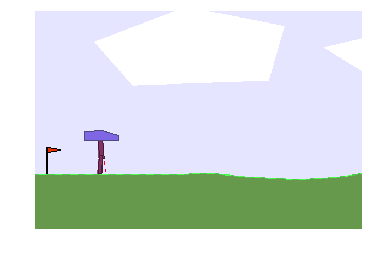

In [83]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [84]:
obs

array([ 2.74713873e-03,  2.63876747e-06, -3.44056450e-04, -1.60000169e-02,
        9.22344476e-02,  7.98698165e-04,  8.60068083e-01,  7.68243025e-04,
        1.00000000e+00,  3.26178409e-02,  7.98681285e-04,  8.53665292e-01,
       -5.43449074e-04,  1.00000000e+00,  4.40813839e-01,  4.45819944e-01,
        4.61422592e-01,  4.89549994e-01,  5.34102559e-01,  6.02460802e-01,
        7.09148586e-01,  8.85931492e-01,  1.00000000e+00,  1.00000000e+00])

이 24개의 숫자에 대한 의미는 [온라인 문서](https://github.com/openai/gym/wiki/BipedalWalker-v2)를 참고하세요.

In [85]:
env.action_space

Box(4,)

In [86]:
env.action_space.low

array([-1., -1., -1., -1.], dtype=float32)

In [87]:
env.action_space.high

array([1., 1., 1., 1.], dtype=float32)

이는 각 다리의 엉덩이 관절의 토크와 발목 관절 토크를 제어하는 연속적인 4D 행동 공간입니다(-1에서 1까지). 연속적인 행동 공간을 다루기 위한 한 가지 방법은 이를 불연속적으로 나누는 것입니다. 예를 들어, 가능한 토크 값을 3개의 값 -1.0, 0.0, 1.0으로 제한할 수 있습니다. 이렇게 하면 가능한 행동은 $3^4=81$개가 됩니다.

In [88]:
from itertools import product

In [89]:
possible_torques = np.array([-1.0, 0.0, 1.0])
possible_actions = np.array(list(product(possible_torques, possible_torques, possible_torques, possible_torques)))
possible_actions.shape

(81, 4)

In [90]:
tf.reset_default_graph()

# 1. 네트워크 구조를 정의합니다
n_inputs = env.observation_space.shape[0]  # == 24
n_hidden = 10
n_outputs = len(possible_actions) # == 625
initializer = tf.variance_scaling_initializer()

# 2. 신경망을 만듭니다
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.selu,
                         kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs,
                         kernel_initializer=initializer)
outputs = tf.nn.softmax(logits)

# 3. 추정 확률에 기초하여 무작위한 행동을 선택합니다
action_index = tf.squeeze(tf.multinomial(logits, num_samples=1), axis=-1)

# 4. 훈련
learning_rate = 0.01

y = tf.one_hot(action_index, depth=len(possible_actions))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]
gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))
training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

아직 훈련되지 않았지만 이 정책 네트워크를 실행해 보죠.

In [91]:
def run_bipedal_walker(model_path=None, n_max_steps = 1000):
    env = gym.make("BipedalWalker-v2")
    frames = []
    with tf.Session() as sess:
        if model_path is None:
            init.run()
        else:
            saver.restore(sess, model_path)
        obs = env.reset()
        for step in range(n_max_steps):
            img = env.render(mode="rgb_array")
            frames.append(img)
            action_index_val = action_index.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            action = possible_actions[action_index_val]
            obs, reward, done, info = env.step(action[0])
            if done:
                break
    env.close()
    return frames

In [92]:
frames = run_bipedal_walker()
video = plot_animation(frames)
HTML(video.to_html5_video())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


안되네요, 걷지를 못합니다. 그럼 훈련시켜 보죠!

In [93]:
n_games_per_update = 10
n_max_steps = 1000
n_iterations = 1000
save_iterations = 10
discount_rate = 0.95

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print("\rIteration: {}/{}".format(iteration + 1, n_iterations), end="")
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_index_val, gradients_val = sess.run([action_index, gradients],
                                                           feed_dict={X: obs.reshape(1, n_inputs)})
                action = possible_actions[action_index_val]
                obs, reward, done, info = env.step(action[0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, "./my_bipedal_walker_pg.ckpt")

Iteration: 1000/1000

In [94]:
frames = run_bipedal_walker("./my_bipedal_walker_pg.ckpt")
video = plot_animation(frames)
HTML(video.to_html5_video())

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from ./my_bipedal_walker_pg.ckpt


/home/haesun/anaconda3/envs/handson-ml/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


최상의 결과는 아니지만 적어도 직립해서 (느리게) 오른쪽으로 이동합니다(훨씬 더 오랜 학습이 필요할 것 같습니다 :). 이 문제에 대한 더 좋은 방법은 액터-크리틱(actor-critic) 알고리즘을 사용하는 것입니다. 이 방법은 행동 공간을 이산화할 필요가 없으므로 훨씬 빠르게 수렴합니다. 이에 대한 더 자세한 내용은 Yash Patel가 쓴 멋진 [블로그 포스트](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-actor-critic-models-f084612cfd69)를 참고하세요.

## 9.
**Comming soon**